# Data Analysis and Plot Creation for Client model Fine-tuning

This notebook serves to generate the useful plot and tables to understand and compare the behaviour of the tested algorithms.

We use a different notebook so that we can experiment plotting data as soon as it starts being available.

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib as mpl
from intellect.io import load, recursive_find_file
from intellect.scoring import knowledge_loss_gain_score
import matplotlib.pyplot as plt

import config

mpl.rcParams['figure.dpi']= 70
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 20)

In [2]:
baseline = pd.Series({'Global': 0.9775778945096064,
 'BENIGN': 0.9777796966295369,
 'Bot': 0.6109215017064846,
 'DDoS': 0.9826666666666667,
 'DoS GoldenEye': 0.9886666666666667,
 'DoS Hulk': 0.9006666666666666,
 'DoS Slowhttptest': 0.9927272727272727,
 'DoS slowloris': 0.9953970080552359,
 'DrDoS_DNS': 0.9973333333333333,
 'DrDoS_LDAP': 0.9993333333333333,
 'DrDoS_MSSQL': 1.0,
 'DrDoS_NTP': 0.9986666666666667,
 'DrDoS_NetBIOS': 0.9993333333333333,
 'DrDoS_SNMP': 1.0,
 'DrDoS_SSDP': 0.9993333333333333,
 'DrDoS_UDP': 0.9993333333333333,
 'FTP-Patator': 0.9974811083123426,
 'Heartbleed': 0.0,
 'Infiltration': 0.2,
 'LDAP': 1.0,
 'MSSQL': 0.9993333333333333,
 'NetBIOS': 1.0,
 'PortScan': 0.9386666666666666,
 'Portmap': 0.9986666666666667,
 'SSH-Patator': 0.7228506787330317,
 'Syn': 0.9966666666666667,
 'TFTP': 0.9973333333333333,
 'UDP': 1.0,
 'UDP-lag': 0.9953333333333333,
 'UDPLag': 0.9074733096085409,
 'Web Attack Brute Force': 0.9292035398230089,
 'Web Attack Sql Injection': 0.3333333333333333,
 'Web Attack XSS': 0.9387755102040817,
 'WebDDoS': 0.30303030303030304})

In [51]:
def load_result_with_filter_and_score(directory, condition=None, ignore_categories=None):
    df = pd.DataFrame()
    for f in recursive_find_file(directory, ".csv"):
        if f.endswith("_history.csv") or f.endswith("_monitored.csv"):
            continue
        if condition and condition not in f:
            continue
        tmp = load(f, index_col=0)
        r = knowledge_loss_gain_score(tmp, seen_categories=config.CLIENT_CATEGORIES if "few_c" in f else None, ignore_categories=ignore_categories).to_frame().T
        r.index = [f.split("/")[-1]]
        df = pd.concat((df, r))
    return df

def plot_end_test_max_eval_metrics(path, condition=None, ignore_categories=None):
    tmp = load_result_with_filter_and_score(path, condition=condition, ignore_categories=ignore_categories)
    idxes = []
    for word in ("truth", "inferred", "'alpha': 0.5", "'alpha': 1"):
        idx = tmp[tmp.index.str.contains(word)]["Loss Unseen"].abs().idxmin()
        idxes.append(idx)
    view = tmp.loc[idxes]
    view.index = ["Ground Truth", "Ground Inferred", "Half Knowledge \nDistillation", "Full Knowledge\nDistillation"]
    view.abs().plot.bar(y=["Loss Seen", "Gain Seen", "Loss Unseen", "Gain Unseen"], ylabel="Accuracy Variation", xlabel="Algorithms", grid=True, rot=0);
    display(view)

def plot_thorugh_time_during_test_eval_metrics(path, path2, path3, path4, ignore_categories=None):
    _, axs = plt.subplots(1,4, figsize=(20, 5))
    maxy = 0
    for ax, pat, name in zip(axs, (path, path2, path3, path4), ("Ground Truth", "Ground Oracle", "Hybrid Truth - Knowledge Distillation", "Knowledge Distillation")):
        f: pd.DataFrame = load(pat + "_monitored.csv", index_col=0)
        f2 = load(pat + ".csv", index_col=0)
        f2.loc["Max Baseline"] = baseline
        ds = pd.DataFrame()
        for i, row in f.iterrows():
            f2.loc["Validation After"] = row
            r = knowledge_loss_gain_score(f2, "Validation After", "Max Baseline", seen_categories=config.CLIENT_CATEGORIES if "few_c" in pat else None, ignore_categories=ignore_categories)
            r = r.to_frame().T
            r.index = [i]
            ds = pd.concat((ds, r))
        ds.abs().plot.line(y=["Loss Seen", "Gain Seen", "Loss Unseen", "Gain Unseen"], ylabel="Accuracy Variation", xlabel="# Train Epochs", title=name, ax=ax, lw=2)
        maxy = max(maxy, ds.abs().max().max())
    for ax in axs:
        ax.set_ylim(top=maxy+0.05)
    
def plot_thorugh_time_during_test_eval_metrics222(path, path2, path3, path4, title="", ignore_categories=None):
    asd = {}
    for pat, name in zip((path, path2, path3, path4), ("Ground Truth", "Ground Oracle", "Hybrid Truth &\nKnowledge Distillation", "Knowledge Distillation")):
        asd[name] = []
        f: pd.DataFrame = load(pat + "_monitored.csv", index_col=0)
        f2 = load(pat + ".csv", index_col=0)
        f2.loc["Max Baseline"] = baseline
        for _, row in f.iterrows():
            f2.loc["Validation After"] = row
            r = knowledge_loss_gain_score(f2, "Validation After", "Max Baseline", seen_categories=config.CLIENT_CATEGORIES if "few_c" in pat else None, ignore_categories=ignore_categories)
            asd[name].append(r["Loss Unseen"])
    asd = pd.DataFrame(asd)
    asd.index += 1
    ax = asd.abs().plot(ylabel="Mean Accuracy Loss", xlabel="# Epochs", legend=True)#title=f"Knowledge Loss on Previous Attacks when Fine-Tuning\nScenario -> {title}"

    #figl, axl = plt.subplots()
    #axl.axis(False)
    #axl.legend(*ax.get_legend_handles_labels(), loc="center", bbox_to_anchor=(0.5, 0.5), ncol=4)
    

## Oracle to Oracle

In [56]:
base =  config.CLIENT_REFIT_OUTPUT_DIR + "o_to_o_few_c/"
f1 = base + "algorithm_ground_truth-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = base + "algorithm_ground_inferred-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = base + "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = base + "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
    

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

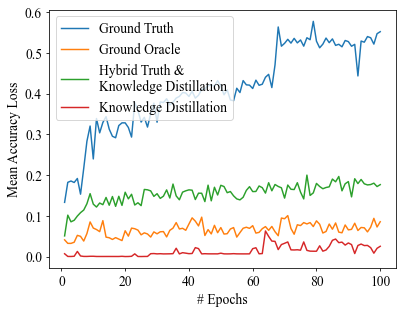

In [57]:
plot_thorugh_time_during_test_eval_metrics222(f1, f2, f3, f4, "Client = Oracle")

In [ ]:
plot_end_test_max_eval_metrics(base)

## Oracle to Pruned Oracle

In [122]:
base =  config.CLIENT_REFIT_OUTPUT_DIR + "o_to_po_few_c_prune_0.55_drop_0.1/"
f1 = "algorithm_ground_truth-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f4 = "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

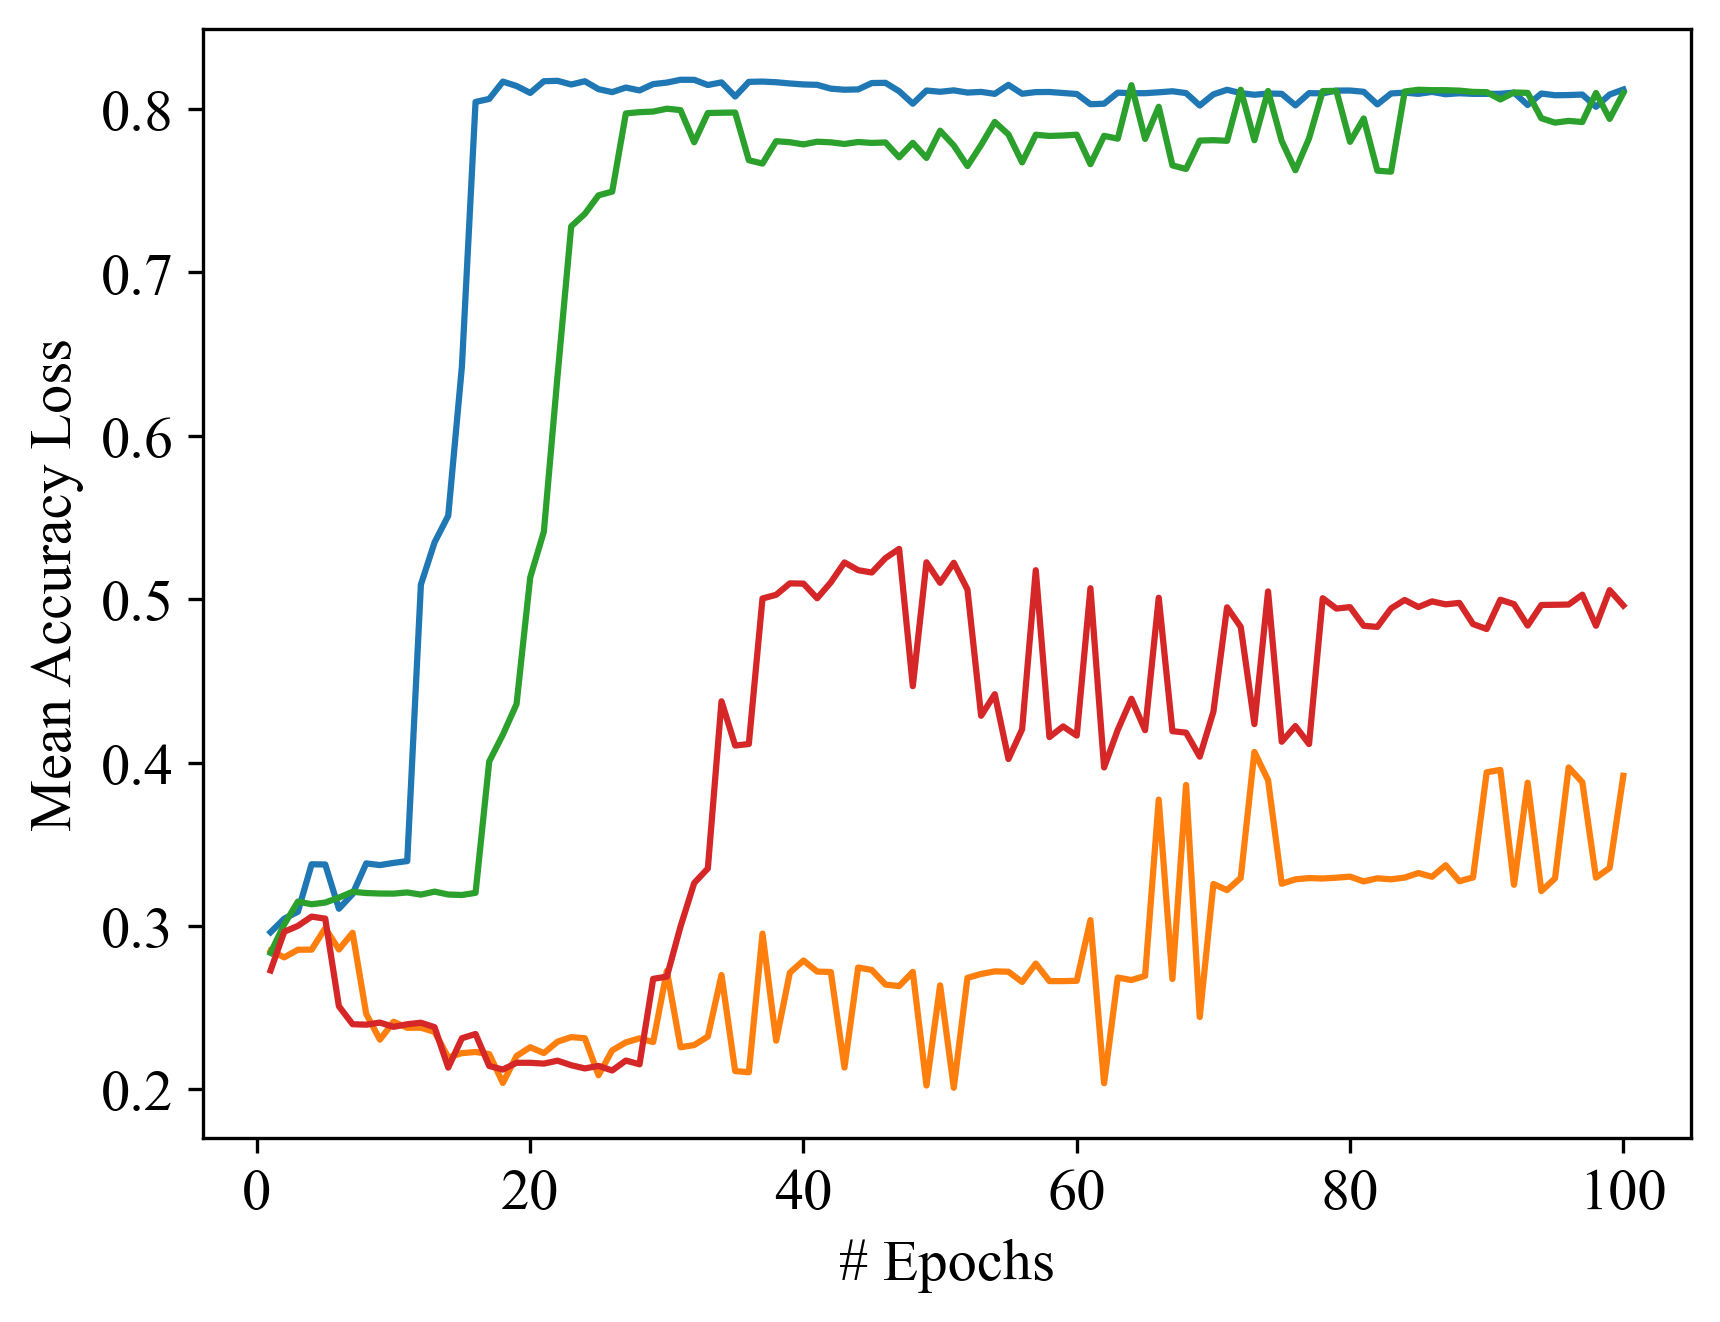

In [124]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4, "")

,Func,Loss Seen,Gain Seen,Loss Unseen,Gain Unseen
Ground Truth,-0.198241,0.000000,0.015630,-0.808593,0.0
Ground Inferred,-0.080902,0.000000,0.002180,-0.325790,0.0
Half Knowledge \nDistillation,-0.186943,0.000000,0.014786,-0.762559,0.0
Full Knowledge\nDistillation,-0.053267,-0.000667,0.005080,-0.217482,0.0


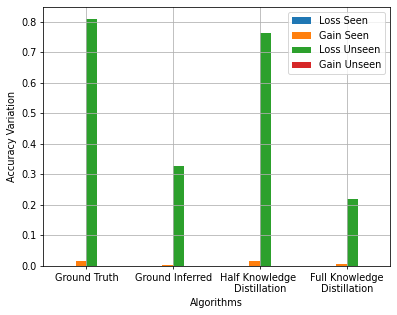

In [15]:
plot_end_test_max_eval_metrics(base)

In [125]:
base =  config.CLIENT_REFIT_OUTPUT_DIR + "o_to_po_few_c_prune_0.5_drop_0.2/"
f1 = "algorithm_ground_truth-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_bilateral-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f4 = "algorithm_knowledge_distillation-availability_bilateral-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

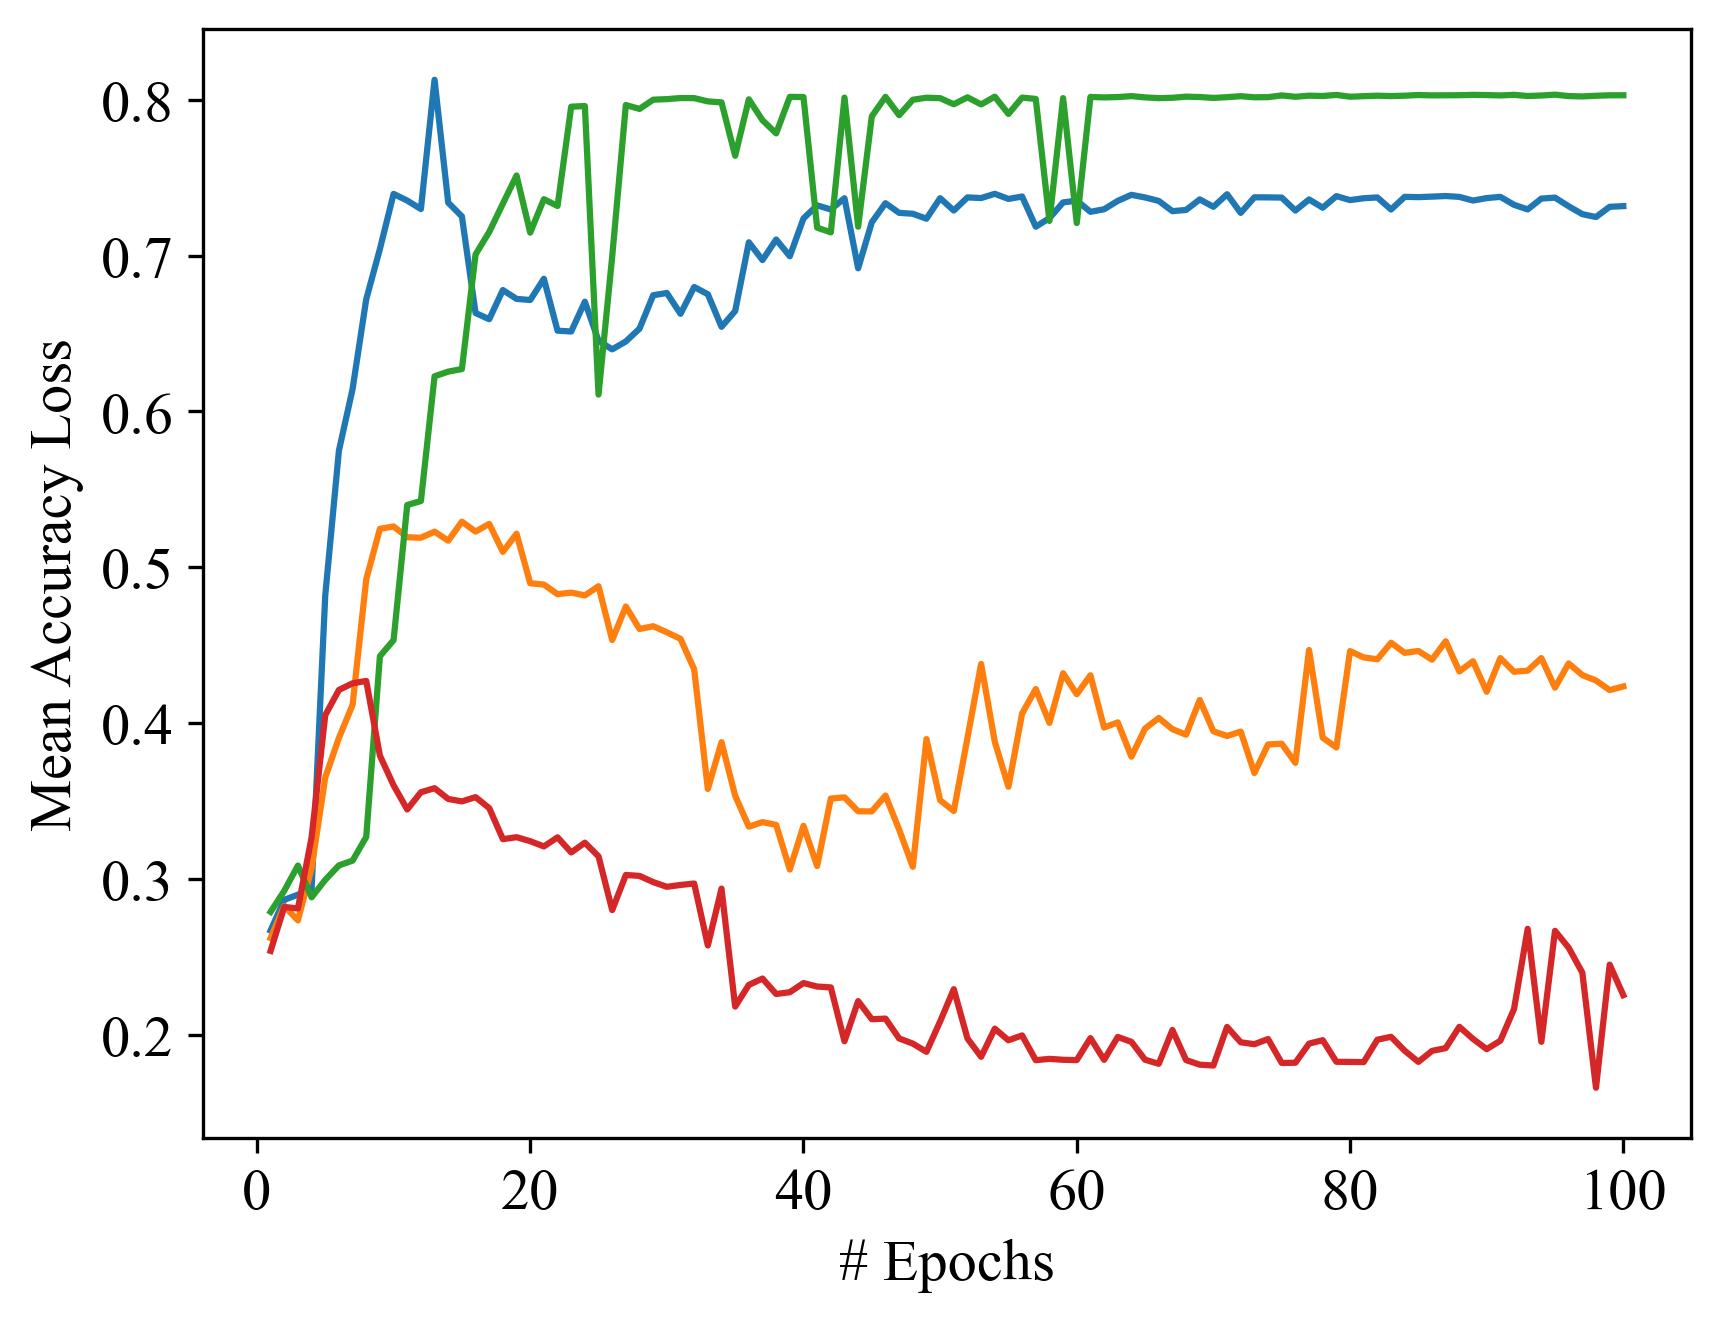

In [127]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4, "")

,Func,Loss Seen,Gain Seen,Loss Unseen,Gain Unseen
Ground Truth,-0.198241,0.000000,0.015630,-0.808593,0.0
Ground Inferred,-0.080902,0.000000,0.002180,-0.325790,0.0
Half Knowledge \nDistillation,-0.186943,0.000000,0.014786,-0.762559,0.0
Full Knowledge\nDistillation,-0.053267,-0.000667,0.005080,-0.217482,0.0


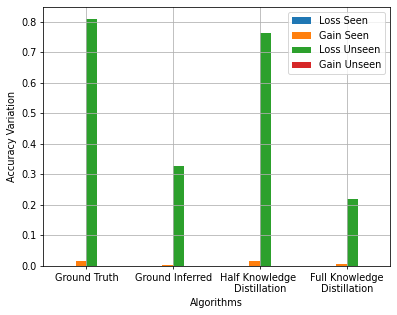

In [15]:
plot_end_test_max_eval_metrics(base)

## Oracle to Edge Oracle

Small subset.

In [37]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_eo_few_c_subsetsize_0.5_drop_0.2/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

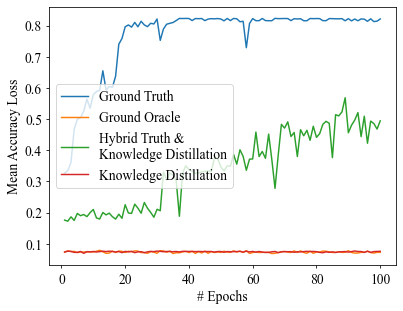

In [38]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4, "")

In [43]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_eo_few_c_subsetsize_0.8_drop_0.2/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_oracle-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

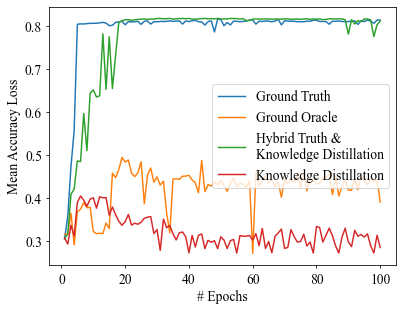

In [44]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

In [47]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_eo_few_c_subsetsize_0.3_drop_0.2/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

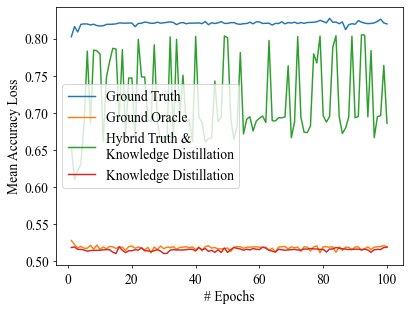

In [48]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

## Oracle to Edge Client

In [8]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_0.5_prune_0.55_drop_0.2/"

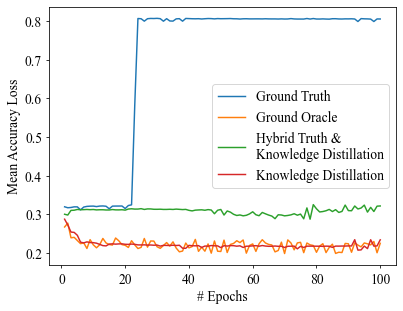

In [9]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4, "")

In [87]:
SUBSET = 0.5
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_{SUBSET}_prune_0.55_drop_0.2/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_none-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

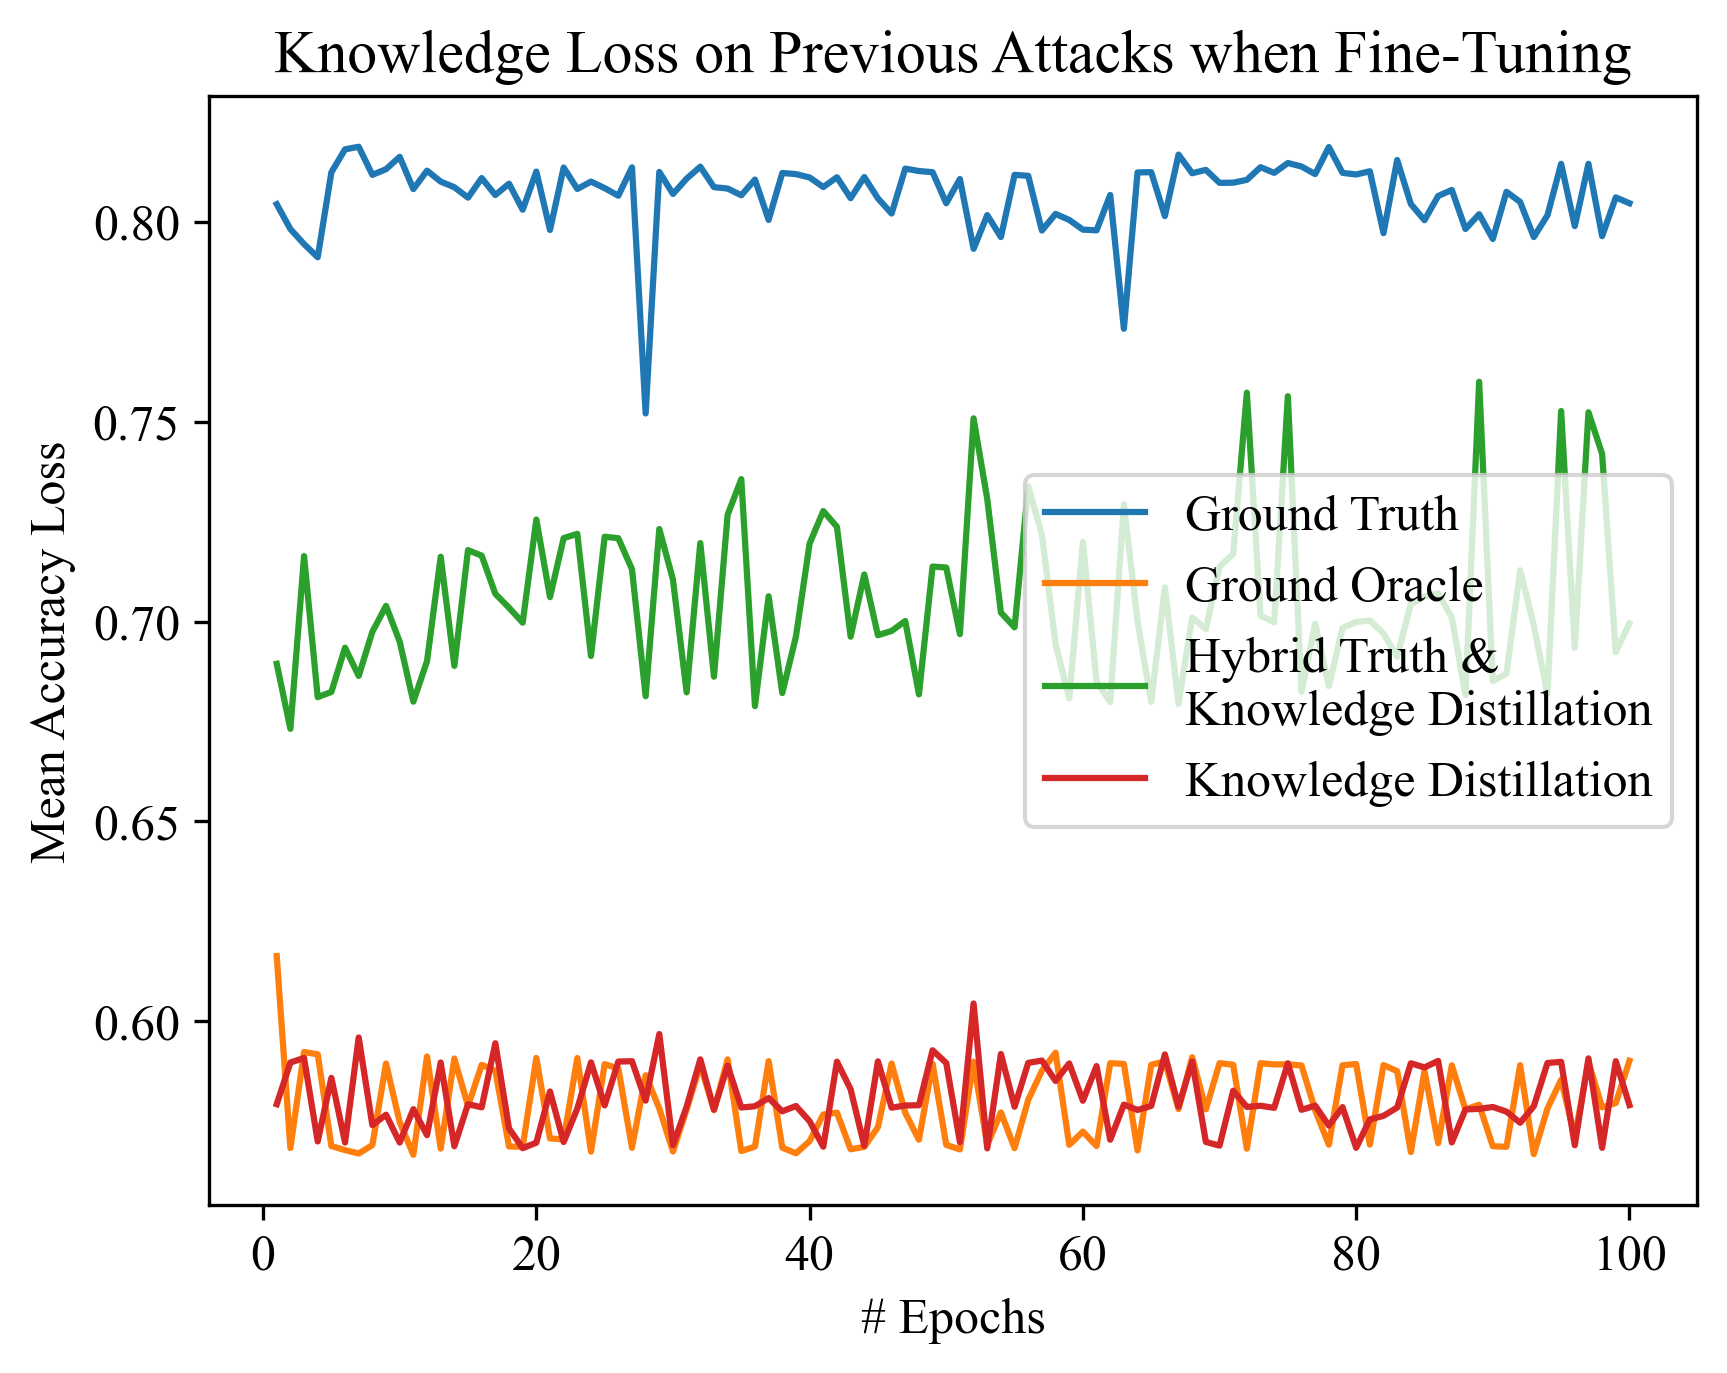

In [99]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

,Func,Loss Seen,Gain Seen,Loss Unseen,Gain Unseen
Ground Truth,-0.133588,0.000,0.059229,-0.593579,0.000000
Ground Inferred,-0.003469,-0.001,0.040066,-0.061153,0.008210
Half Knowledge \nDistillation,-0.010548,0.000,0.053376,-0.095568,0.000000
Full Knowledge\nDistillation,-0.010641,-0.005,0.035489,-0.081259,0.008208


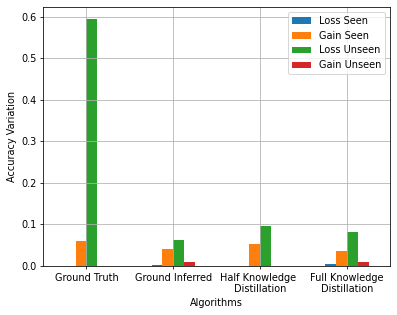

In [8]:
plot_end_test_max_eval_metrics(base)

In [68]:
SUBSET = 0.5
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_{SUBSET}_prune_0.55_drop_0.2/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_oracle-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

In [ ]:
plot_thorugh_time_during_test_eval_metrics(base + f1, base + f2, base + f3, base + f4)

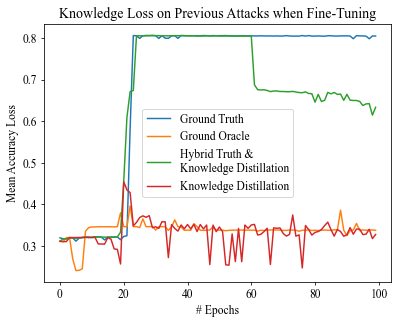

In [69]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

In [14]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_0.1_prune_0.25_drop_0.1/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_oracle-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

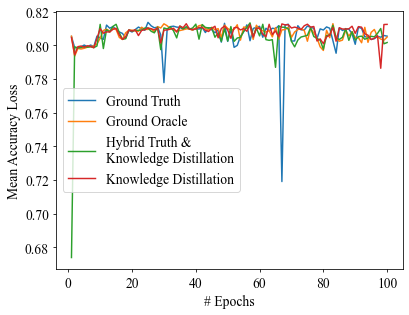

In [15]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

In [20]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_0.3_prune_0.3_drop_0.1/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_oracle-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

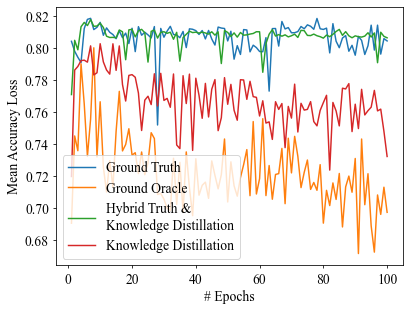

In [21]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)

In [22]:
base = config.CLIENT_REFIT_OUTPUT_DIR + f"o_to_ec_few_c_subsetsize_0.8_prune_0.55_drop_0.1/"

f1 = "algorithm_ground_truth-availability_none-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f2 = "algorithm_ground_inferred-availability_oracle-learn_input_client-max_epochs_100-epochs_wo_improve_100-batch_size_512"
f3 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 0.5}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 
f4 = "algorithm_knowledge_distillation-availability_oracle-learn_input_client-learn_kwargs_{'alpha': 1}-max_epochs_100-epochs_wo_improve_100-batch_size_512" 

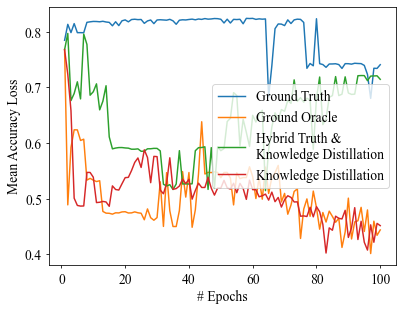

In [23]:
plot_thorugh_time_during_test_eval_metrics222(base + f1, base + f2, base + f3, base + f4)